In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt

import time as t
import itertools
import numpy as np

import controller as con

from tqdm.auto import tqdm

/home/jack/Documents/School/Thesis/Thesis/MS-Thesis/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the model and create MjData and Renderer objects to go along with it

$\texttt{model}$ contains all information about the robot/environment; this includes all parts, links, joints, and the ground.

$\texttt{data}$ contains all information about the state of $\texttt{model}$. We can read information about the environment's state here, and apply forces at joints. This is where all the physics modeling takes place.

$\texttt{renderer}$ contains all necessary information to render the scene.

In [2]:
# simulation environment
model = mujoco.MjModel.from_binary_path("Quadruped MJB.mjb")
data = mujoco.MjData(model)

# visualization
renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
camera.distance = 1.5
camera.trackbodyid = 2
camera.azimuth = 30

# model configuration
model.opt.gravity = (0, 0, -9.81)   # set simulation gravity
model.opt.integrator = 3            # select integrator (0 = Euler, 1 = implicitfast, 2 = implicit, 3 = rk4)
model.opt.timestep = .002           # set timestep

## Define functions for running the robot's controllers

$\texttt{model\_to\_abs()}$ accounts for zero offsets and incorrect axis directions, and $\texttt{abs\_to\_model()}$ does the reverse conversion. These functions are necessary because the .mjb file for the robot does not have the joints zeroed in the correct place; ideally this would be fixed in the model, but due to the poor performance of the Solidworks to URDF extension, this option is preferred.

$\texttt{update\_controller()}$ reads state information about the environment, inputs it to the controller, runs the controller, and applies the controller outputs to the robot's joints.

$ \texttt{data.qpos} = [body , body , body , body , body , body , fr\_hip , fr\_knee , fl\_hip , fl\_knee , rr\_hip , rr\_knee , rl\_hip , rl\_knee] $

$ \texttt{data.actuator} = ['kd\ fl\ hip', 'kd\ fl\ knee', 'kd\ fr\ hip', 'kd\ fr\ knee', 'kd\ rl\ hip', 'kd\ rl\ knee', 'kd\ rr\ hip', 'kd\ rr\ knee', 'kp\ fl\ hip', 'kp\ fl\ knee', 'kp\ fr\ hip', 'kp\ fr\ knee', 'kp\ rl\ hip', 'kp\ rl\ knee', 'kp\ rr\ hip', 'kp\ rr\ knee']$

In [3]:
def model_to_abs(mod_pos):
    pos_offsets = np.array([0,0,0,0,0,0,.736600934,-1.51121634,.737159549,-1.51177616,.736600879,-1.51121629,.737164507,-1.51177608])

    abs_pos = mod_pos + pos_offsets
    return abs_pos

def abs_to_model(abs_pos):
    pos_offsets = np.array([0,0,0,0,0,0,.736600934,-1.51121634,.737159549,-1.51177616,.736600879,-1.51121629,.737164507,-1.51177608])

    mod_pos = abs_pos - pos_offsets
    return mod_pos

In [4]:
# create the controller objects
fr_leg = con.leg_controller()
fl_leg = con.leg_controller()
rr_leg = con.leg_controller()
rl_leg = con.leg_controller()

def update_controller(model,data):
    pd_target = np.zeros(14)
    pd_target = np.array([0,0,0,0,0,0,0.60590654,-1.38528975 ,0.60590654,-1.38528975 ,0.60590654,-1.38528975,0.60590654,-1.38528975])
    curr_pos = model_to_abs(data.qpos[1:])

    # run gait scheduling layer

    # run leg control layer
    fr_leg.curr_pos = curr_pos[6:8]
    fl_leg.curr_pos = curr_pos[8:10]
    rr_leg.curr_pos = curr_pos[10:12]
    rl_leg.curr_pos = curr_pos[12:14]
    pd_target[6:8] = fr_leg.run_controller(.5)
    pd_target[8:10] = fl_leg.run_controller(.5)
    pd_target[10:12] = rr_leg.run_controller(.5)
    pd_target[12:14] = rl_leg.run_controller(.5)

    # run PD layer
    current_target = model_to_abs(pd_target)
    current_dtarget = data.qvel
    data.ctrl[0] = current_target[6]
    data.ctrl[2] = current_target[7]
    data.ctrl[4] = current_target[8]
    data.ctrl[6] = current_target[9]
    data.ctrl[8] = current_target[10]
    data.ctrl[10] = current_target[11]
    data.ctrl[12] = current_target[12]
    data.ctrl[14] = current_target[13]
    data.ctrl[1] = 0
    data.ctrl[3] = 0
    data.ctrl[5] = 0
    data.ctrl[7] = 0
    data.ctrl[9] = 0
    data.ctrl[11] = 0
    data.ctrl[13] = 0
    data.ctrl[15] = 0
    
update_controller(model,data)

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!


Simulate and render the simulation

In [5]:
duration = 5  # (seconds)
framerate = 30  # (Hz)

# Simulate and display video.
n_steps = int(duration/model.opt.timestep + 1)
frames = []
positions = np.zeros((n_steps,model.nv+1))
controller_setpoints = np.zeros((n_steps,2))
controller_time = np.zeros(n_steps)
time = np.zeros(n_steps)
mujoco.mj_resetData(model, data)  # Reset state and time.
i = 0
for i in tqdm(range(n_steps)):
  # step the simulator
  mujoco.mj_step(model, data)

  # apply forces
  temp = t.time()
  update_controller(model,data)
  controller_time[i] = t.time()-temp

  # store any data we need stored
  positions[i] = data.qpos
  time[i] = data.time
  controller_setpoints[i] = fr_leg.run_controller(data.time)
  i = i + 1

  # render the scene if we're at the correct timestep to have a frame
  if len(frames) < data.time * framerate:
    camera.azimuth = data.time*75
    renderer.update_scene(data,camera)
    pixels = renderer.render()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

  2%|▏         | 38/2501 [00:00<00:06, 379.67it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

  5%|▍         | 120/2501 [00:00<00:03, 637.51it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

  8%|▊         | 209/2501 [00:00<00:03, 752.34it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 18%|█▊        | 444/2501 [00:00<00:02, 1015.94it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 33%|███▎      | 819/2501 [00:00<00:01, 1156.28it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 37%|███▋      | 935/2501 [00:00<00:01, 1130.38it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 49%|████▊     | 1217/2501 [00:01<00:01, 1235.54it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 59%|█████▉    | 1484/2501 [00:01<00:00, 1249.90it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 70%|██████▉   | 1744/2501 [00:01<00:00, 1264.22it/s]

Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

 79%|███████▉  | 1983/2501 [00:01<00:00, 1136.44it/s]


Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics are asking the leg to go somewhere it can't reach!
Inverse kinematics a

KeyboardInterrupt: 

Plot Recorded Data

Text(0.5, 1.0, 'Joint Positions')

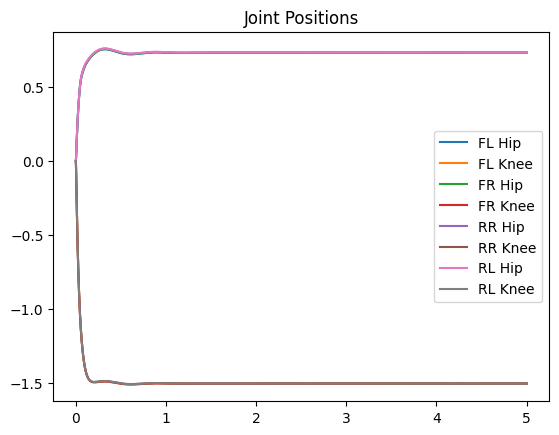

In [ ]:
'''plt.plot(time,np.array(positions[:,1]),label='Body Free 1')
plt.plot(time,np.array(positions[:,2]),label='Body Free 2')
plt.plot(time,np.array(positions[:,3]),label='Body Free 3')
plt.plot(time,np.array(positions[:,4]),label='Body Free 4')
plt.plot(time,np.array(positions[:,5]),label='Body Free 5')
plt.plot(time,np.array(positions[:,6]),label='Body Free 6')'''
plt.plot(time,np.array(positions[:,7]),label='FL Hip')
plt.plot(time,np.array(positions[:,8]),label='FL Knee')
plt.plot(time,np.array(positions[:,9]),label='FR Hip')
plt.plot(time,np.array(positions[:,10]),label='FR Knee')
plt.plot(time,np.array(positions[:,11]),label='RR Hip')
plt.plot(time,np.array(positions[:,12]),label='RR Knee')
plt.plot(time,np.array(positions[:,13]),label='RL Hip')
plt.plot(time,np.array(positions[:,14]),label='RL Knee')
'''plt.plot(time,np.array(controller_setpoints[:,0]),label='Hip Setpoint')
plt.plot(time,np.array(controller_setpoints[:,1]),label='Knee Setpoint')'''
plt.legend()
plt.title("Joint Positions")

Time The Functions

In [ ]:
print(f"Averagve Controller Step Time: {np.mean(controller_time)} seconds")

temp = t.time()
fr_leg.bezier(fr_leg.flight_traj_x,fr_leg.flight_traj_y)
print(f"Bezier curve generation time: {t.time() - temp}")

temp = t.time()
fr_leg.init(1)
print(f"Init state time: {t.time() - temp}")

temp = t.time()
fr_leg.flight(1)
print(f"Flight state time: {t.time() - temp}")

Averagve Sim Controller Step Time: 0.00040289431941456814 seconds
Bezier curve generation time: 0.0037217140197753906
Init state time: 0.0003902912139892578
Flight state time: 0.0002875328063964844
